In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import hdbscan

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
os.chdir('C:/Users/admin/OneDrive/Documents/TrabajoTesis')

In [4]:
df = pd.read_excel("Cluster/Faenas25.xlsx")

In [5]:
# Limpiar nombres de columnas
df.columns = ['RutEmpresa' if col == 'RutEmpresa' else col.lstrip() for col in df.columns]

# Limpiar espacios dentro de las columnas (excepto RutEmpresa)
for col in df.select_dtypes(include='object').columns:
    if col != 'RutEmpresa':
        df[col] = df[col].str.strip()

In [6]:
df = df[df['RecursoPrimarioInstalacion'] == 'COBRE']
df.shape

(21158, 27)

In [7]:
df = df.drop(columns=[
    'RegionFaena', 'ProvinciaFaena', 'ComunaFaena', 'NombreFaena', 'IdFaena',
    'RegionInstalacion', 'NombreInstalacion', 'RecursoMineroInstalacion',
    'TipoRecursoInstalacion', 'IdInstalacion', 'Norte', 'Este', 'Datum'
])

### Pipeline

In [8]:

class HDBSCANWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, min_cluster_size=30, cluster_selection_epsilon=0.08):
        self.min_cluster_size = min_cluster_size
        self.cluster_selection_epsilon = cluster_selection_epsilon
        self.clusterer_ = None

    def fit(self, X, y=None):
        self.clusterer_ = hdbscan.HDBSCAN(
            min_cluster_size=self.min_cluster_size,
            cluster_selection_epsilon=self.cluster_selection_epsilon
        )
        self.clusterer_.fit(X)
        return self

    def transform(self, X):
        # Returns cluster labels as a column
        return self.clusterer_.labels_.reshape(-1, 1)


### Con inactivas

In [9]:

coords = df[['Longitud', 'Latitud']].to_numpy()

model_pipeline_40 = Pipeline([
    ("zscore", StandardScaler()),
    ("hdbscan", HDBSCANWrapper(min_cluster_size=40, cluster_selection_epsilon=0.08))
])

model_pipeline_70 = Pipeline([
    ("zscore", StandardScaler()),
    ("hdbscan", HDBSCANWrapper(min_cluster_size=70, cluster_selection_epsilon=0.08))
])

In [10]:
# Fit pipeline
model_pipeline_40.fit(coords)
model_pipeline_70.fit(coords)

# Get cluster labels
labels_40 = model_pipeline_40.transform(coords)
labels_70 = model_pipeline_70.transform(coords)

# Convert to DataFrame
df['cluster_40'] = labels_40
df['cluster_70'] = labels_70


C:\Users\admin\AppData\Local\Temp\ipykernel_1852\417147987.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_clusters)


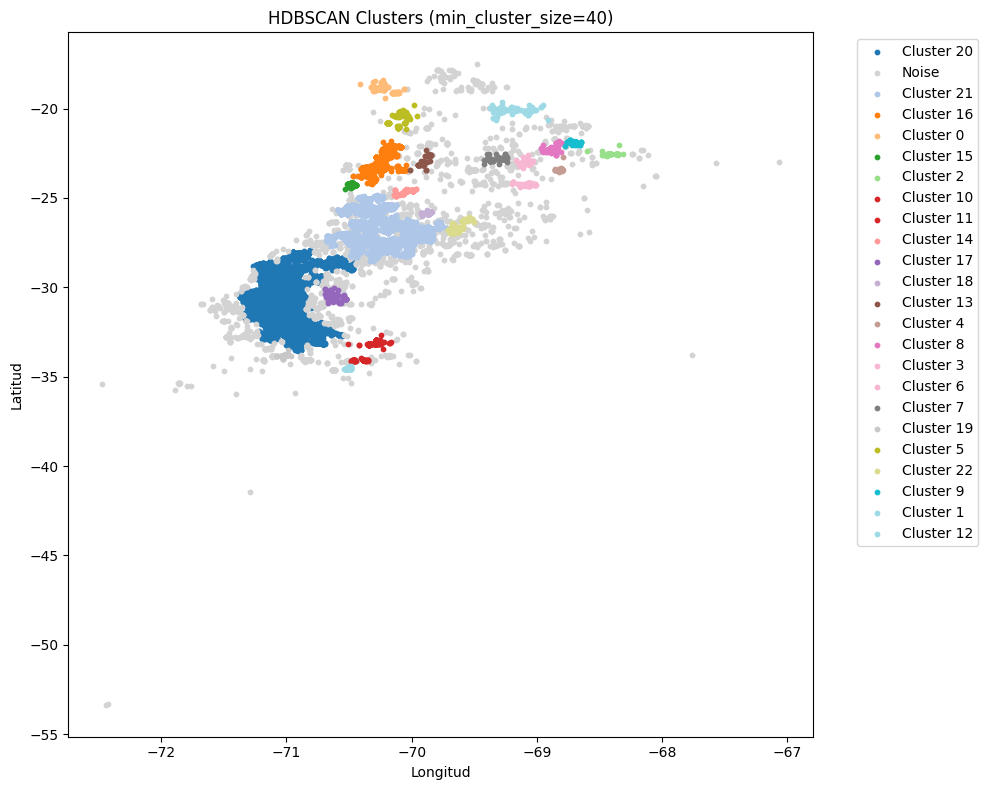

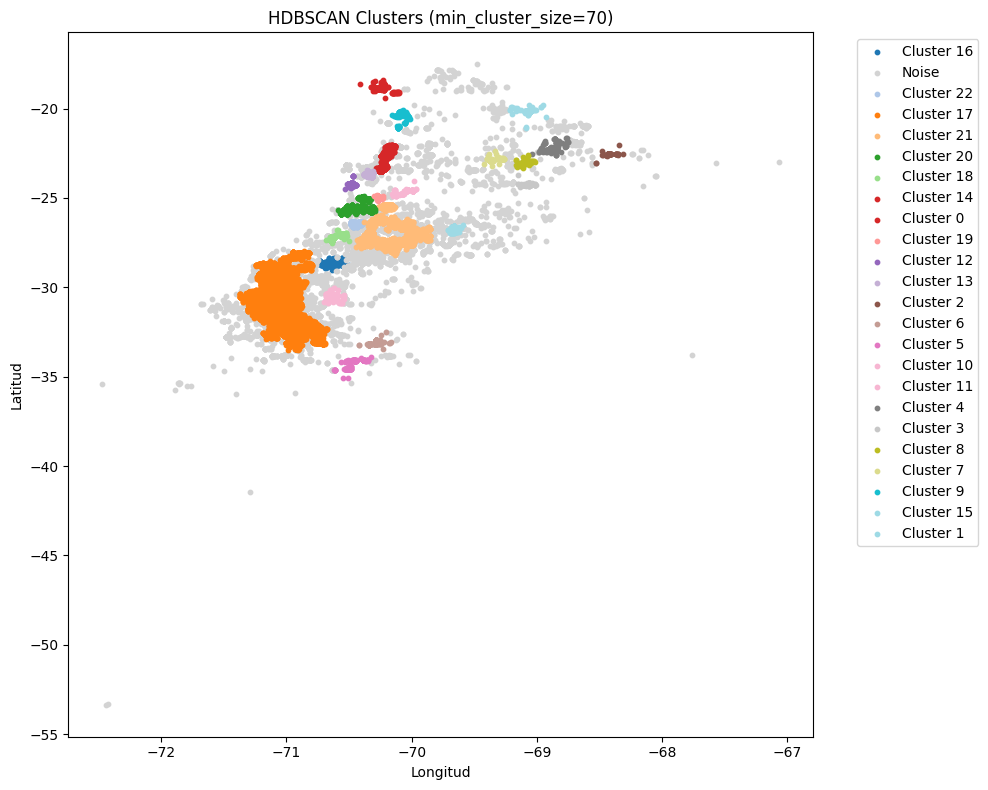

In [11]:
def plot_hdbscan_clusters(df, label_col, title):
    plt.figure(figsize=(10,8))
    
    # Get unique clusters
    clusters = df[label_col].unique()
    num_clusters = len(clusters)
    colors = cm.get_cmap('tab20', num_clusters)
    
    for i, cluster in enumerate(clusters):
        mask = df[label_col] == cluster
        # Optional: treat noise (-1) as another color
        if cluster == -1:
            plt.scatter(df.loc[mask, 'Longitud'], df.loc[mask, 'Latitud'],
                        color='lightgray', s=10, label='Noise')
        else:
            plt.scatter(df.loc[mask, 'Longitud'], df.loc[mask, 'Latitud'],
                        color=colors(i), s=10, label=f'Cluster {cluster}')
    
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot min_cluster_size = 40
plot_hdbscan_clusters(df, 'cluster_40', 'HDBSCAN Clusters (min_cluster_size=40)')

# Plot min_cluster_size = 70
plot_hdbscan_clusters(df, 'cluster_70', 'HDBSCAN Clusters (min_cluster_size=70)')


### Sin inacctivas

In [12]:
df_activas = df[df['Estado'] == 'ACTIVA']

In [13]:
coords_activas = df_activas[['Longitud', 'Latitud']].to_numpy()

model_pipeline_40 = Pipeline([
    ("zscore", StandardScaler()),
    ("hdbscan", HDBSCANWrapper(min_cluster_size=40, cluster_selection_epsilon=0.08))
])

model_pipeline_70 = Pipeline([
    ("zscore", StandardScaler()),
    ("hdbscan", HDBSCANWrapper(min_cluster_size=70, cluster_selection_epsilon=0.08))
])

In [14]:
# Fit pipeline
model_pipeline_40.fit(coords_activas)
model_pipeline_70.fit(coords_activas)

# Get cluster labels
labels_40 = model_pipeline_40.transform(coords_activas)
labels_70 = model_pipeline_70.transform(coords_activas)

# Convert to DataFrame
df_activas['cluster_40'] = labels_40
df_activas['cluster_70'] = labels_70

C:\Users\admin\AppData\Local\Temp\ipykernel_1852\3155459219.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_activas['cluster_40'] = labels_40
C:\Users\admin\AppData\Local\Temp\ipykernel_1852\3155459219.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_activas['cluster_70'] = labels_70


C:\Users\admin\AppData\Local\Temp\ipykernel_1852\417147987.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_clusters)


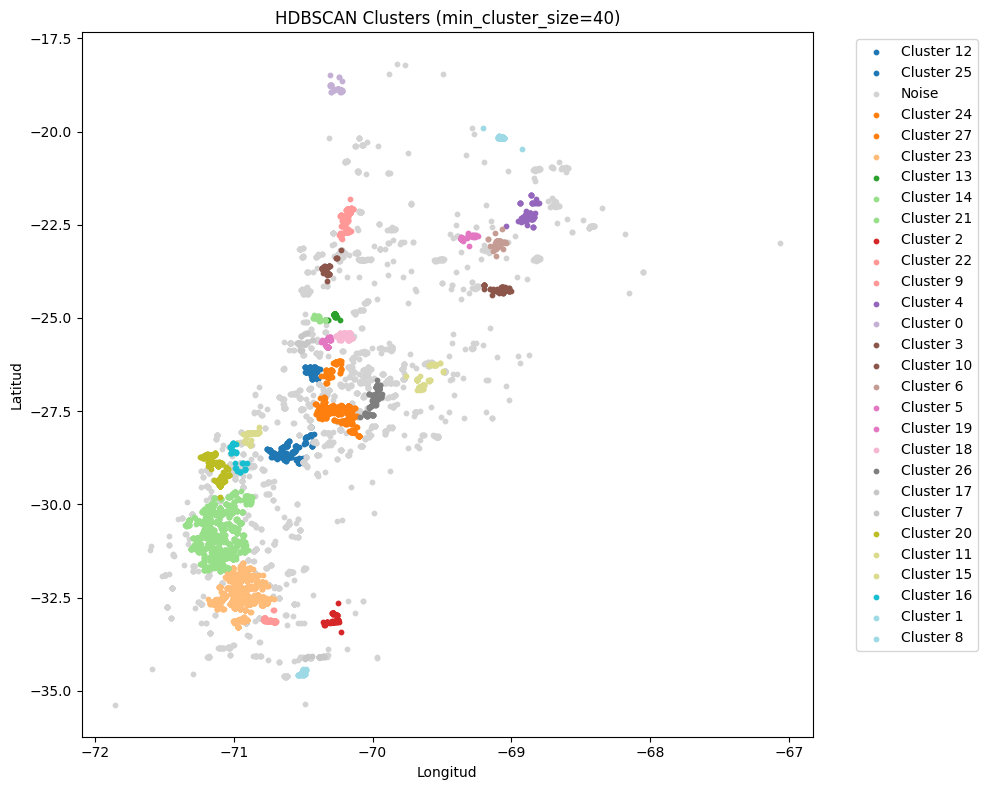

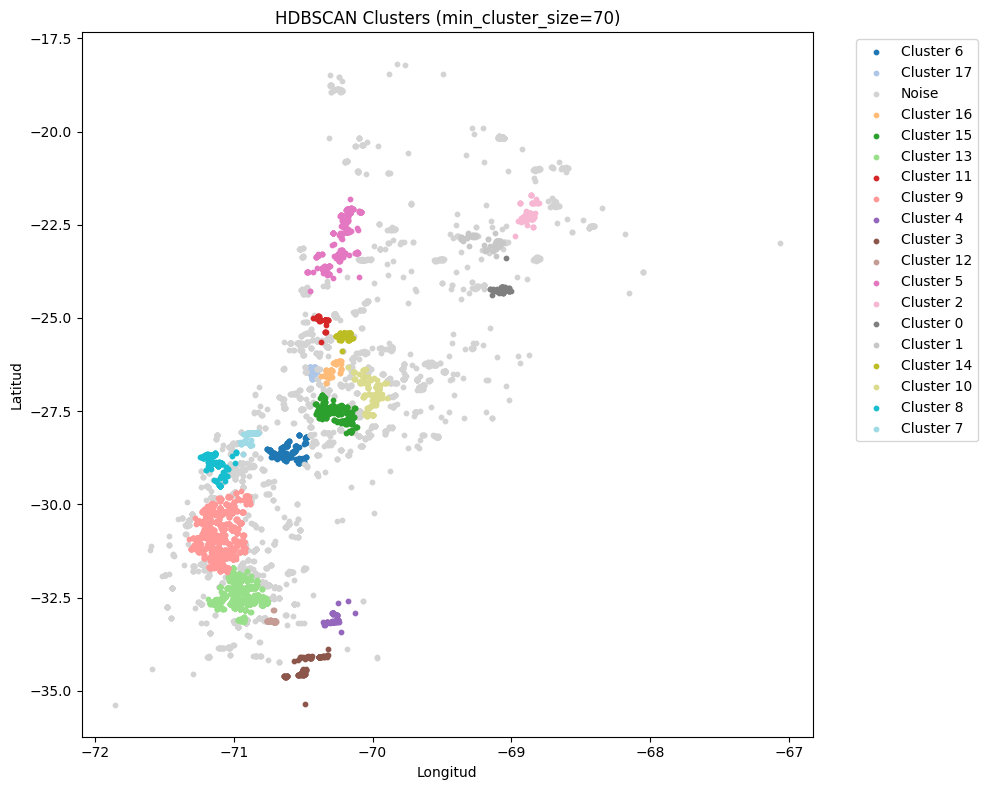

In [15]:
# Plot min_cluster_size = 40
plot_hdbscan_clusters(df_activas, 'cluster_40', 'HDBSCAN Clusters (min_cluster_size=40)')

# Plot min_cluster_size = 70
plot_hdbscan_clusters(df_activas, 'cluster_70', 'HDBSCAN Clusters (min_cluster_size=70)')

In [16]:
df = df[df['Estado'] == 'ACTIVA']

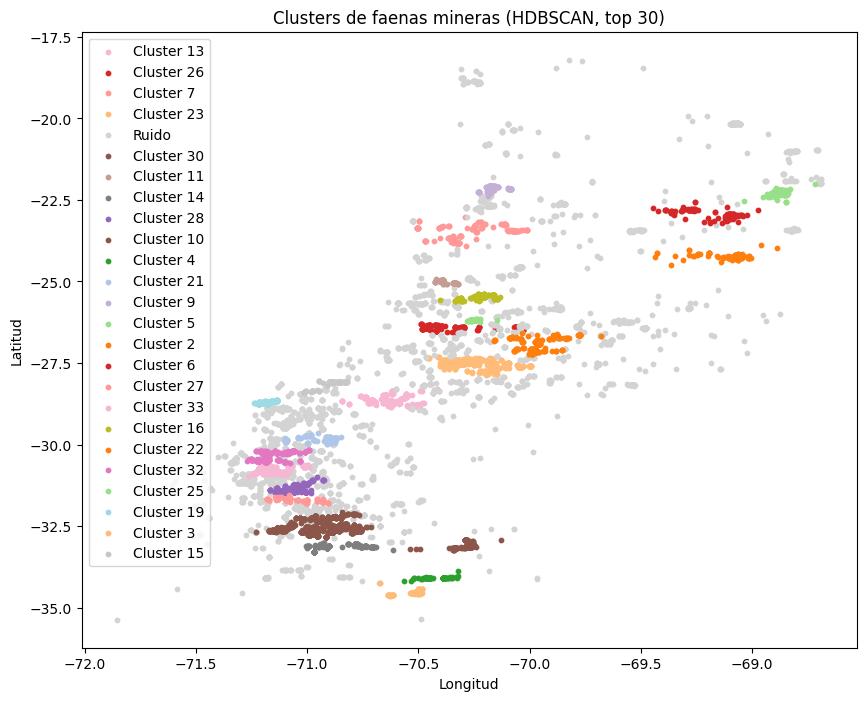

In [17]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Remove outliers using z-score ===
coords = df[['Longitud', 'Latitud']].to_numpy()
z_scores = np.abs((coords - coords.mean(axis=0)) / coords.std(axis=0))
mask = (z_scores[:,0] < 3) & (z_scores[:,1] < 3)  # keep points within 3 std dev
df_clean = df[mask].copy()
coords_clean = df_clean[['Longitud', 'Latitud']].to_numpy()

# === Step 2: Fit HDBSCAN on cleaned data ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,       
    cluster_selection_epsilon=0.08
)
df_clean['cluster'] = clusterer.fit_predict(coords_clean)

# === Step 3: Keep only top 30 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(25).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 4: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

clusters = df_clean['cluster'].unique()
for cluster in clusters:
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras (HDBSCAN, top 30)')
plt.legend()
plt.show()

In [18]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from shapely.geometry import MultiPoint
import numpy as np

# Use the df_clean that includes sub-clusters of 18
df_map = df_clean.copy()

# Convert all cluster labels to string
df_map['cluster'] = df_map['cluster'].astype(str)
unique_clusters = sorted(df_map['cluster'].unique())

# Compute map center
center_lat = df_map['Latitud'].mean()
center_lon = df_map['Longitud'].mean()

# Create base map
m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles="CartoDB positron")

# Define color map
cmap = cm.get_cmap('tab20', len(unique_clusters))

# Draw clusters
for i, cluster in enumerate(unique_clusters):
    df_cluster = df_map[df_map['cluster'] == cluster]
    
    # Identify noise / outliers
    is_noise = 'noise' in cluster or cluster == '-1'
    color = 'lightgray' if is_noise else colors.rgb2hex(cmap(i % 20))
    
    # Draw polygons only for real clusters
    if len(df_cluster) > 2 and not is_noise:
        points = [tuple(x) for x in df_cluster[['Latitud', 'Longitud']].values]
        hull = MultiPoint(points).convex_hull
        if hull.geom_type == 'Polygon':
            folium.Polygon(
                locations=[(y, x) for x, y in hull.exterior.coords],
                color=color,
                fill=True,
                fill_opacity=0.2,
                weight=1
            ).add_to(m)
    
    # Draw connecting lines only for real clusters
    if len(df_cluster) > 1 and not is_noise:
        folium.PolyLine(
            locations=df_cluster[['Latitud', 'Longitud']].values.tolist(),
            color=color,
            weight=2,
            opacity=0.5,
            popup=f"Cluster {cluster} ({len(df_cluster)} faenas)"
        ).add_to(m)
    
    # Add individual points for all clusters
    for _, row in df_cluster.iterrows():
        popup_text = f"""
        <b>Cluster:</b> {cluster}<br>
        <b>Empresa:</b> {row.get('RutEmpresa', 'N/A')}<br>
        <b>Categoría:</b> {row.get('CategoriaFaena', 'N/A')}
        """
        folium.CircleMarker(
            location=[row['Latitud'], row['Longitud']],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=0.8,
            popup=folium.Popup(popup_text, max_width=250)
        ).add_to(m)

# Save map
output_path = "clusters_faenas_connected_sub18_fixed_outliers.html"
m.save(output_path)
print(f"✅ Map saved as '{output_path}'. Open it in your browser.")

C:\Users\admin\AppData\Local\Temp\ipykernel_1852\1938546101.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_clusters))


✅ Map saved as 'clusters_faenas_connected_sub18_fixed_outliers.html'. Open it in your browser.


In [21]:
df2 = pd.read_csv("Bases/faenas_with_accessibility.csv")

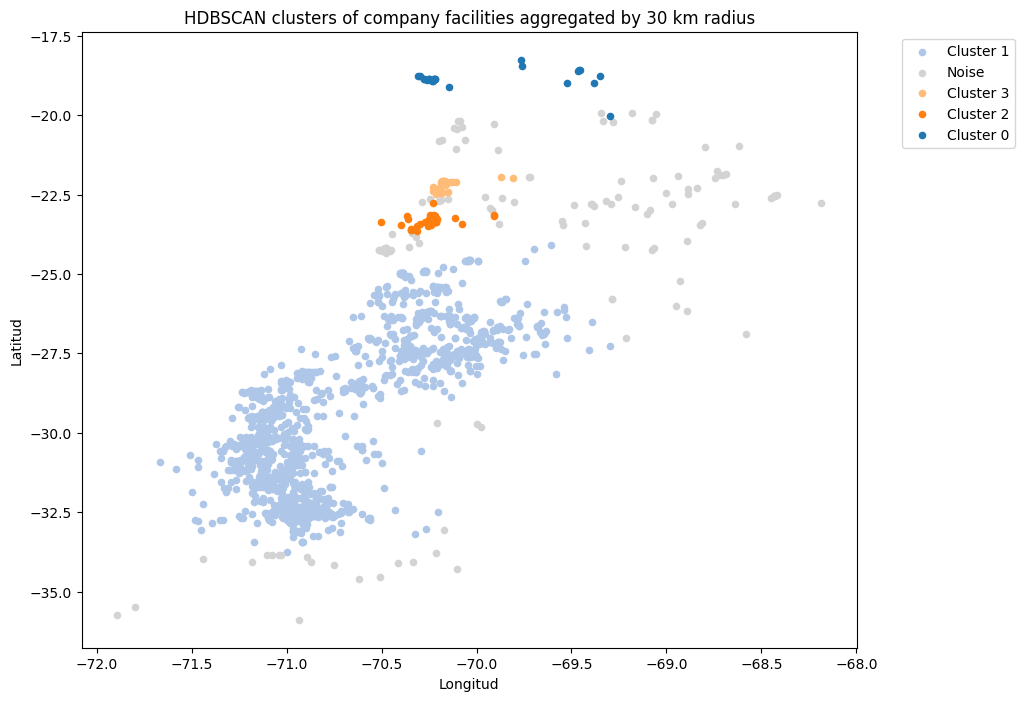

In [22]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import hdbscan
import matplotlib.pyplot as plt

# --- PARAMETERS ---
RADIUS_KM = 30  # 30 km radius to merge same-company facilities
EARTH_RADIUS_KM = 6371.0088

# Columns
LAT_COL = 'Latitud'
LON_COL = 'Longitud'
COMPANY_COL = 'NombreEmpresa'

# --- Step 0: Copy and convert coordinates to radians ---
df_clean = df2.copy()
coords_rad = np.deg2rad(df_clean[[LAT_COL, LON_COL]].to_numpy())

# --- Step 1: Group facilities within 30 km radius for each company ---
aggregated_rows = []

for company, group in df_clean.groupby(COMPANY_COL):
    if len(group) == 1:
        aggregated_rows.append(group.iloc[0])
        continue
    
    # Use BallTree with haversine metric for distance in radians
    group_coords_rad = np.deg2rad(group[[LAT_COL, LON_COL]].to_numpy())
    tree = BallTree(group_coords_rad, metric='haversine')
    
    # Find all points within RADIUS_KM
    radius_rad = RADIUS_KM / EARTH_RADIUS_KM
    unvisited = set(range(len(group)))
    
    while unvisited:
        idx = unvisited.pop()
        indices = tree.query_radius([group_coords_rad[idx]], r=radius_rad)[0]
        cluster_idx = list(set(indices) & unvisited) + [idx]
        # Mark these points as visited
        unvisited -= set(cluster_idx)
        
        # Aggregate: mean coordinates + count of facilities
        subset = group.iloc[cluster_idx]
        centroid_lat = subset[LAT_COL].mean()
        centroid_lon = subset[LON_COL].mean()
        row = subset.iloc[0].copy()
        row[LAT_COL] = centroid_lat
        row[LON_COL] = centroid_lon
        row['n_facilities'] = len(subset)
        aggregated_rows.append(row)

# Build aggregated DataFrame
df_agg = pd.DataFrame(aggregated_rows)

# --- Step 2: Apply HDBSCAN on aggregated points ---
agg_coords = df_agg[[LON_COL, LAT_COL]].to_numpy()
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, cluster_selection_epsilon=0.14)
df_agg['cluster'] = clusterer.fit_predict(agg_coords)

# --- Step 3: Plot clusters ---
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')
for cluster in df_agg['cluster'].unique():
    mask = df_agg['cluster'] == cluster
    color = 'lightgray' if cluster == -1 else cmap(hash(cluster) % 20)
    plt.scatter(df_agg.loc[mask, LON_COL], df_agg.loc[mask, LAT_COL], s=20, color=color,
                label=f'Cluster {cluster}' if cluster != -1 else 'Noise')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('HDBSCAN clusters of company facilities aggregated by 30 km radius')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

In [23]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from shapely.geometry import MultiPoint

# Use the aggregated DataFrame from previous step (df_agg)
df_map = df_agg.copy()
df_map['cluster'] = df_map['cluster'].astype(str)

unique_clusters = sorted(df_map['cluster'].unique())
center_lat = df_map['Latitud'].mean()
center_lon = df_map['Longitud'].mean()

# Create base map
m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles="CartoDB positron")

# Colormap for clusters
cmap = cm.get_cmap('tab20', len(unique_clusters))

for i, cluster in enumerate(unique_clusters):
    df_cluster = df_map[df_map['cluster'] == cluster]
    
    # Noise in gray
    is_noise = cluster == '-1'
    color = 'lightgray' if is_noise else colors.rgb2hex(cmap(i % 20))
    
    for _, row in df_cluster.iterrows():
        popup_text = f"""
        <b>Cluster:</b> {cluster}<br>
        <b>Empresa:</b> {row['NombreEmpresa']}<br>
        <b>Faenas agrupadas:</b> {row['n_facilities']}<br>
        <b>Lat/Lon:</b> {row['Latitud']:.4f}, {row['Longitud']:.4f}
        """
        folium.CircleMarker(
            location=[row['Latitud'], row['Longitud']],
            radius=3 + np.log1p(row['n_facilities'])*2,  # radius proportional to number of facilities
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=250)
        ).add_to(m)
    
    # Optional: draw convex hull for clusters (if more than 2 points)
    if len(df_cluster) > 2 and not is_noise:
        points = [tuple(x) for x in df_cluster[['Latitud','Longitud']].values]
        hull = MultiPoint(points).convex_hull
        if hull.geom_type == 'Polygon':
            folium.Polygon(
                locations=[(y,x) for x,y in hull.exterior.coords],
                color=color,
                fill=True,
                fill_opacity=0.2,
                weight=1
            ).add_to(m)

# Save map
output_path = "aggregated_30km_hdbscan_map.html"
m.save(output_path)
print(f"✅ Map saved as '{output_path}'. Open it in your browser.")

C:\Users\admin\AppData\Local\Temp\ipykernel_1852\1481900528.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_clusters))


✅ Map saved as 'aggregated_30km_hdbscan_map.html'. Open it in your browser.
